<center><h1>Gunadi_Eben_Final_Project</h1></center>

Name: Eben Gunadi
<br>
Github Username: egunadi
<br>
USC ID: 3976793880

## 1. Text Classification

Import packages

In [223]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten


### (a) Download the Reviews Data Set

In [224]:
# In this problem, we are trying to build a classifier to analyze the sentiment of reviews. You are provided with text data in two folders: one folder involves positive reviews, and one folder involves negative reviews.

positive_path = "../data/pos/"
negative_path = "../data/neg/"

positive_files = glob.glob(positive_path + "*.txt")
negative_files = glob.glob(negative_path + "*.txt")

In [225]:
file_id_pattern = re.compile("\d{3}")

positive_df = pd.DataFrame()

for file in positive_files:
    file_title = Path(file).stem
    file_id = int(file_id_pattern.search(file_title).group(0))

    with open(file, "r") as f:
        text = f.read()
        dict = {"id": file_id, "title": file_title, "text": text}

        df = pd.DataFrame(dict, index=[0])
        positive_df = pd.concat([positive_df, df], ignore_index=True)

In [226]:
negative_df = pd.DataFrame()

for file in negative_files:
    file_title = Path(file).stem
    file_id = int(file_id_pattern.search(file_title).group(0))

    with open(file, "r") as f:
        text = f.read()
        dict = {"id": file_id, "title": file_title, "text": text}

        df = pd.DataFrame(dict, index=[0])
        negative_df = pd.concat([negative_df, df], ignore_index=True)

In [227]:
positive_df = positive_df.set_index("id")
negative_df = negative_df.set_index("id")

In [228]:
print(positive_df.shape)
print(negative_df.shape)

(1000, 2)
(1000, 2)


In [229]:
positive_df.head()

,title,text
id,,
839,cv839_21467,assume nothing . \nthe phrase is perhaps one o...
34,cv034_29647,plot : derek zoolander is a male model . \nhe ...
908,cv908_16009,i actually am a fan of the original 1961 or so...
748,cv748_12786,a movie that's been as highly built up as the ...
253,cv253_10077,""" good will hunting "" is two movies in one : ..."


In [230]:
negative_df.head()

,title,text
id,,
676,cv676_22202,bad . bad . \nbad . \nthat one word seems to p...
839,cv839_22807,isn't it the ultimate sign of a movie's cinema...
155,cv155_7845,""" gordy "" is not a movie , it is a 90-minute-..."
465,cv465_23401,disconnect the phone line . \ndon't accept the...
398,cv398_17047,when robert forster found himself famous again...


### (b) Data Exploration and Pre-processing

#### (i) Binary Encoding

In [231]:
# You can use binary encoding for the sentiments , i.e y = 1 for positive sentiments and y = −1 for negative sentiments.
# Per Piazza question @562, use 0 and 1 instead since we'll be using a sigmoid activation function in the neural network.

positive_df["sentiment"] = 1
negative_df["sentiment"] = 0

In [232]:
positive_df.head()

,title,text,sentiment
id,,,
839,cv839_21467,assume nothing . \nthe phrase is perhaps one o...,1
34,cv034_29647,plot : derek zoolander is a male model . \nhe ...,1
908,cv908_16009,i actually am a fan of the original 1961 or so...,1
748,cv748_12786,a movie that's been as highly built up as the ...,1
253,cv253_10077,""" good will hunting "" is two movies in one : ...",1


In [233]:
negative_df.head()

,title,text,sentiment
id,,,
676,cv676_22202,bad . bad . \nbad . \nthat one word seems to p...,0
839,cv839_22807,isn't it the ultimate sign of a movie's cinema...,0
155,cv155_7845,""" gordy "" is not a movie , it is a 90-minute-...",0
465,cv465_23401,disconnect the phone line . \ndon't accept the...,0
398,cv398_17047,when robert forster found himself famous again...,0


#### (ii) Data Cleaning

In [234]:
# The data are pretty clean. Remove the punctuation and numbers from the data.

# Remove punctuation and normalize case
positive_df["text"] = positive_df["text"].apply(lambda x: re.sub('[^\w\s]', '', x).lower())
negative_df["text"] = negative_df["text"].apply(lambda x: re.sub('[^\w\s]', '', x).lower())

# Remove numbers
positive_df["text"] = positive_df["text"].apply(lambda x: re.sub('\d+', '', x))
negative_df["text"] = negative_df["text"].apply(lambda x: re.sub('\d+', '', x))

# Also collapse multiple spaces
positive_df["text"] = positive_df["text"].apply(lambda x: re.sub('\s+', ' ', x).strip())
negative_df["text"] = negative_df["text"].apply(lambda x: re.sub('\s+', ' ', x).strip())

In [235]:
positive_df.head()

,title,text,sentiment
id,,,
839,cv839_21467,assume nothing the phrase is perhaps one of th...,1
34,cv034_29647,plot derek zoolander is a male model he is als...,1
908,cv908_16009,i actually am a fan of the original or so live...,1
748,cv748_12786,a movie thats been as highly built up as the t...,1
253,cv253_10077,good will hunting is two movies in one an inde...,1


In [236]:
negative_df.head()

,title,text,sentiment
id,,,
676,cv676_22202,bad bad bad that one word seems to pretty much...,0
839,cv839_22807,isnt it the ultimate sign of a movies cinemati...,0
155,cv155_7845,gordy is not a movie it is a minutelong sesame...,0
465,cv465_23401,disconnect the phone line dont accept the char...,0
398,cv398_17047,when robert forster found himself famous again...,0


#### (iii) Separate Test and Train Data

In [237]:
# The name of each text file starts with cv number. Use text files 0-699 in each class for training and 700-999 for testing.

positive_df = positive_df.sort_index()
negative_df = negative_df.sort_index()

positive_train = positive_df.loc[0:699]
positive_test = positive_df.loc[700:999]

negative_train = negative_df.loc[0:699]
negative_test = negative_df.loc[700:999]

In [238]:
print(positive_train.shape)
print(positive_test.shape)
print(negative_train.shape)
print(negative_test.shape)

(700, 3)
(300, 3)
(700, 3)
(300, 3)


#### (iv) Unique Words

In [239]:
# Count the number of unique words in the whole dataset (train + test) and print it out.

positive_words = [word 
                  for text in positive_df["text"]
                  for word in text.split()]

positive_unique_words = set(positive_words)

negative_words = [word
                  for text in negative_df["text"]
                  for word in text.split()]

negative_unique_words = set(negative_words)

all_unique_words = positive_unique_words.union(negative_unique_words)

In [240]:
print("Number of unique words in the whole dataset:", len(all_unique_words))

Number of unique words in the whole dataset: 47037


#### (v) Review Length

In [241]:
# Calculate the average review length and the standard deviation of review lengths. Report the results.

positive_df["review_length"] = positive_df["text"].apply(lambda x: len(x.split()))
negative_df["review_length"] = negative_df["text"].apply(lambda x: len(x.split()))

all_review_lengths = pd.concat([positive_df["review_length"], negative_df["review_length"]])

average_review_length = all_review_lengths.mean()
std_review_length = all_review_lengths.std()

In [242]:
print("Average review length:", average_review_length)
print("Standard deviation of review lengths:", std_review_length)

Average review length: 644.3575
Standard deviation of review lengths: 285.0513950898525


#### (vi) Histogram

/Users/ebengunadi/anaconda3/envs/dsci552-final-project/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ebengunadi/anaconda3/envs/dsci552-final-project/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


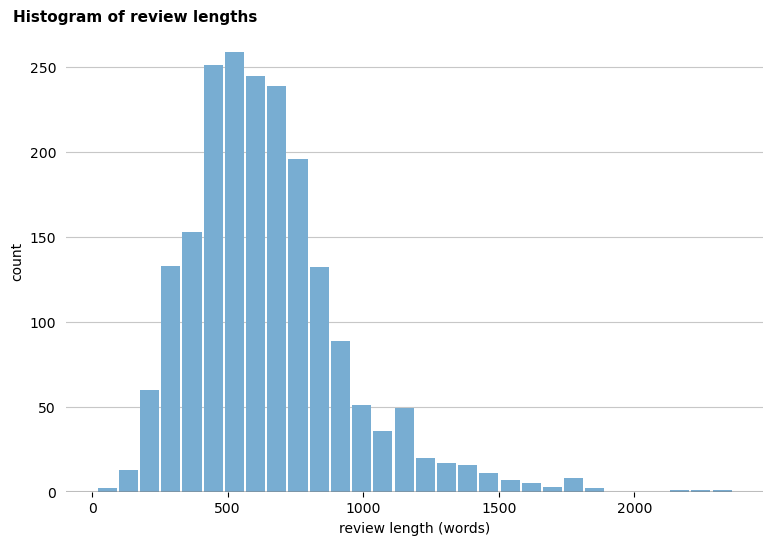

In [243]:
# Plot the histogram of review lengths.

fig, ax = plt.subplots(figsize=(9, 6))

# First layer for grid visibility, white bars with no edges
sns.histplot(data=all_review_lengths, bins=30, color='white', alpha=1, shrink=0.9, edgecolor='none')
# Second layer for actual data visibility, slightly transparent, with no edges
sns.histplot(data=all_review_lengths, bins=30, alpha=0.6, shrink=0.9, edgecolor='none')
ax.set_axisbelow(True)
ax.grid(axis='y', alpha=0.7)

plt.title("Histogram of review lengths", x=0.1, weight='bold', fontsize=11)
plt.xlabel("review length (words)")
plt.ylabel("count")

# Remove top and right axis lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left']. set_visible(False)  # Disabling the left spine
ax.spines['bottom']. set_visible(False)  # Disabling the bottom spine
ax.tick_params(left=False) # Disable the ticks on the bottom and left axes

# Add a horizontal line at y=0 to represent where the x-axis would be
ax.axhline(y=0, color='gray', linewidth=1.5, alpha=0.5)  

plt.show()


#### (vii) Tokenization

In [244]:
# To represent each text (= data point), there are many ways. In NLP/Deep Learning terminology, this task is called tokenization. It is common to represent text using popularity/ rank of words in text. The most common word in the text will be represented as 1, the second most common word will be represented as 2, etc. Tokenize each text document using this method.
# Per footnote 2: "Keras has an API called Tokenizer. It can yield bag of words, one-hot encoded features, etc."

# Initialize tokenizer
# Set a specific num_words (vocabulary size)
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")

# Fit the tokenizer on the texts
all_texts = pd.concat([positive_df['text'], negative_df['text']])
tokenizer.fit_on_texts(all_texts)

# Transform texts into sequences
positive_df['sequences'] = tokenizer.texts_to_sequences(positive_df['text'])
negative_df['sequences'] = tokenizer.texts_to_sequences(negative_df['text'])

In [245]:
positive_df.head()

,title,text,sentiment,review_length,sequences
id,,,,,
0,cv000_29590,films adapted from comic books have had plenty...,1,679,"[68, 2746, 30, 356, 1635, 33, 91, 1048, 5, 628..."
1,cv001_18431,every now and then a movie comes along from a ...,1,650,"[151, 145, 4, 103, 3, 28, 200, 265, 30, 3, 151..."
2,cv002_15918,youve got mail works alot better than it deser...,1,416,"[730, 288, 3643, 380, 1, 154, 59, 10, 1214, 6,..."
3,cv003_11664,jaws is a rare film that grabs your attention ...,1,997,"[3245, 7, 3, 1401, 16, 9, 1, 172, 560, 143, 10..."
4,cv004_11636,moviemaking is a lot like being the general ma...,1,644,"[4790, 7, 3, 212, 40, 110, 2, 835, 3096, 5, 25..."


In [246]:
negative_df.head()

,title,text,sentiment,review_length,sequences
id,,,,,
0,cv000_29416,plot two teen couples go to a church party dri...,0,688,"[99, 80, 1084, 3705, 130, 6, 3, 1978, 784, 370..."
1,cv001_19502,the happy bastards quick movie review damn tha...,0,240,"[2, 675, 1, 1059, 28, 456, 1534, 9, 1, 2961, 2..."
2,cv002_17424,it is movies like these that make a jaded movi...,0,483,"[10, 7, 102, 40, 111, 9, 87, 3, 1, 28, 716, 1,..."
3,cv003_12683,quest for camelot is warner bros first feature...,0,462,"[1907, 13, 1, 7, 2801, 4759, 81, 1, 1, 507, 6,..."
4,cv004_12641,synopsis a mentally unstable man undergoing ps...,0,718,"[1976, 3, 3493, 1, 116, 1, 1, 2946, 3, 413, 30..."


#### (viii) Review Length Threshold

In [247]:
# Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

# Calculate the 70th percentile of review lengths
L = int(all_review_lengths.quantile(0.7))
print("70th percentile of review lengths:", L)

70th percentile of review lengths: 737


#### (ix) Zero-pad Review Length

In [248]:
# Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L.
# Per footnote 3: "Keras has pad sequences for doing this."

# Pad and truncate sequences
positive_padded = pad_sequences(positive_df['sequences'], maxlen=L, truncating='post', padding='post')
negative_padded = pad_sequences(negative_df['sequences'], maxlen=L, truncating='post', padding='post')

# Update DataFrames with padded sequences
positive_df['padded_sequences'] = list(positive_padded)
negative_df['padded_sequences'] = list(negative_padded)

In [249]:
# Check max and min review lengths after padding and truncating
print(positive_df['padded_sequences'].apply(len).max())
print(negative_df['padded_sequences'].apply(len).max())
print(positive_df['padded_sequences'].apply(len).min())
print(negative_df['padded_sequences'].apply(len).min())


737
737
737
737


### (c) Word Embeddings

#### (i) Generate Word Embeddings

In [250]:
# One can use tokenized text as inputs to a deep neural network. However, a recent breakthrough in NLP suggests that more sophisticated representations of text yield better results. These sophisticated representations are called word embeddings. “Word embedding is a term used for representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning.” Most deep learning modules (including Keras) provide a convenient way to convert positive integer representations of words into a word embedding by an “Embedding layer.” The layer accepts arguments that define the mapping of words into embeddings, including the maximum number of expected words also called the vocabulary size (e.g. the largest integer value). The layer also allows you to specify the dimension for each word vector, called the “output dimension.” We would like to use a word embedding layer for this project. Assume that we are interested in the top 5,000 words. This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000 words in the document. If you feel more adventurous, use all the words that appear in this corpus. Choose the length of the embedding vector for each word to be 32. Hence, each document is represented as a 32 × L matrix.
# Per footnote 5: "This is done by setting an argument in the embedding layer provided by Keras. Example: model.add(Embedding(top words, 32, input length=max words)), where top words=5,000 and max words=L."

# Define the model
embedding_model = Sequential()

# Add an Embedding layer
# 'L' is the length calculated previously and should be used as the input length for each sequence
# Vocabulary size is 5000, and each word is represented as a 32-dimensional vector
embedding_model.add(Embedding(input_dim=5000, output_dim=32, input_length=L))


#### (ii) Flatten the Matrix

In [251]:
# Flatten the matrix of each document to a vector.

embedding_model.add(Flatten()) # Flatten the embeddings to use them as features for MLP

# Convert sequences to numpy arrays
positive_sequences = np.array(positive_df['padded_sequences'].tolist())
negative_sequences = np.array(negative_df['padded_sequences'].tolist())

# Generate embeddings
positive_embeddings = embedding_model.predict(positive_sequences)
negative_embeddings = embedding_model.predict(negative_sequences)

# Convert array to list for DataFrame storage
positive_df['document_embeddings'] = positive_embeddings.tolist()
negative_df['document_embeddings'] = negative_embeddings.tolist()


32/32 [==============================] - 0s 408us/step


In [252]:
positive_df.head()

,title,text,sentiment,review_length,sequences,padded_sequences,document_embeddings
id,,,,,,,
0,cv000_29590,films adapted from comic books have had plenty...,1,679,"[68, 2746, 30, 356, 1635, 33, 91, 1048, 5, 628...","[68, 2746, 30, 356, 1635, 33, 91, 1048, 5, 628...","[-0.010623611509799957, -0.012660693377256393,..."
1,cv001_18431,every now and then a movie comes along from a ...,1,650,"[151, 145, 4, 103, 3, 28, 200, 265, 30, 3, 151...","[151, 145, 4, 103, 3, 28, 200, 265, 30, 3, 151...","[-0.013288009911775589, -0.006615780293941498,..."
2,cv002_15918,youve got mail works alot better than it deser...,1,416,"[730, 288, 3643, 380, 1, 154, 59, 10, 1214, 6,...","[730, 288, 3643, 380, 1, 154, 59, 10, 1214, 6,...","[-0.0462319515645504, -0.03171362727880478, 0...."
3,cv003_11664,jaws is a rare film that grabs your attention ...,1,997,"[3245, 7, 3, 1401, 16, 9, 1, 172, 560, 143, 10...","[3245, 7, 3, 1401, 16, 9, 1, 172, 560, 143, 10...","[-0.042613543570041656, -0.014202654361724854,..."
4,cv004_11636,moviemaking is a lot like being the general ma...,1,644,"[4790, 7, 3, 212, 40, 110, 2, 835, 3096, 5, 25...","[4790, 7, 3, 212, 40, 110, 2, 835, 3096, 5, 25...","[-0.03362365812063217, -0.0067601799964904785,..."


In [253]:
negative_df.head()

,title,text,sentiment,review_length,sequences,padded_sequences,document_embeddings
id,,,,,,,
0,cv000_29416,plot two teen couples go to a church party dri...,0,688,"[99, 80, 1084, 3705, 130, 6, 3, 1978, 784, 370...","[99, 80, 1084, 3705, 130, 6, 3, 1978, 784, 370...","[-0.012285567820072174, 0.010243821889162064, ..."
1,cv001_19502,the happy bastards quick movie review damn tha...,0,240,"[2, 675, 1, 1059, 28, 456, 1534, 9, 1, 2961, 2...","[2, 675, 1, 1059, 28, 456, 1534, 9, 1, 2961, 2...","[-0.037728048861026764, -0.025620747357606888,..."
2,cv002_17424,it is movies like these that make a jaded movi...,0,483,"[10, 7, 102, 40, 111, 9, 87, 3, 1, 28, 716, 1,...","[10, 7, 102, 40, 111, 9, 87, 3, 1, 28, 716, 1,...","[0.025285754352808, 0.026400569826364517, -0.0..."
3,cv003_12683,quest for camelot is warner bros first feature...,0,462,"[1907, 13, 1, 7, 2801, 4759, 81, 1, 1, 507, 6,...","[1907, 13, 1, 7, 2801, 4759, 81, 1, 1, 507, 6,...","[0.006593666970729828, -0.011522747576236725, ..."
4,cv004_12641,synopsis a mentally unstable man undergoing ps...,0,718,"[1976, 3, 3493, 1, 116, 1, 1, 2946, 3, 413, 30...","[1976, 3, 3493, 1, 116, 1, 1, 2946, 3, 413, 30...","[-0.021586382761597633, -0.045250263065099716,..."


### (d) Multi-Layer Perceptron

#### (i) Train a MLP

In [27]:
# Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

#### (ii) Train and Test Accuracies

In [28]:
# Report the train and test accuracies of this model.

### (e) One-Dimensional Convolutional Neural Network

Although CNNs are mainly used for image data, they can also be applied to text data, as text also has adjacency information. Keras supports one-dimensional convolutions and pooling by the Conv1D and MaxPooling1D classes respectively.

#### (i) Insert a Conv1D Layer

In [29]:
# After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

#### (ii) Train and Test Accuracies

In [30]:
# Report the train and test accuracies of this model.

### (f) Long Short-Term Memory Recurrent Neural Network 

The structure of the LSTM we are going to use is shown in the following figure.

![](LSTM_structure.png)

#### (i) Train the Model

In [31]:
# Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.

#### (ii) Train and Test Accuracies

In [32]:
# Report the train and test accuracies of this model.

## References and Citations

- https://www.kaggle.com/code/alexisbcook/distributions